# 신용카드 사용자 연체 예측 AI 경진대회 
**사용자의 신용카드 대금 연체 정도를 예측 By 신용카드 사용자들의 개인 신상정보 데이터**


#### Font 설정

In [21]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system() 

    if system_name == 'Darwin': 
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(Colab) 
        !apt-get install fonts-nanum -qq > /dev/null 
        !fc-cache -fv 

        import matplotlib as mpl
        mpl.font_manager._rebuild() 
        findfont = mpl.font_manager.fontManager.findfont 
        mpl.font_manager.findfont = findfont 
        mpl.backends.backend_agg.findfont = findfont 

        font_family = "NanumBarunGothic" 
    return font_family

### Code

In [22]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import re 
import seaborn as sns 

ModuleNotFoundError: No module named 'seaborn'

In [23]:
os.getcwd()
# path = ''

'/Users/seunguk/Documents/likelion/credit-now'

In [24]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

#### 변수 설명
index  
gender: 성별  
car: 차량 소유 여부  
reality: 부동산 소유 여부  
child_num: 자녀 수  
income_total: 연간 소득  
income_type: 소득 분류  
							['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']  

edu_type: 교육 수준  
							['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']  

family_type: 결혼 여부  
							['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']  

house_type: 생활 방식  
							['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']  

DAYS_BIRTH: 출생일  
							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미  

DAYS_EMPLOYED: 업무 시작일    
							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미  , 양수 값은 고용되지 않은 상태를 의미함  

FLAG_MOBIL: 핸드폰 소유 여부    
work_phone: 업무용 전화 소유 여부    
phone: 전화 소유 여부    
email: 이메일 소유 여부    
occyp_type: 직업 유형	  												 
family_size: 가족 규모  
begin_month: 신용카드 발급 월  
							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미  

credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도  
							=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함  

In [25]:
train.head() 

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [9]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [7]:
train['gender'].value_counts()

F    17697
M     8760
Name: gender, dtype: int64

In [29]:
train['occyp_type'].describe()

count        18286
unique          18
top       Laborers
freq          4512
Name: occyp_type, dtype: object

In [28]:
print(sum(train['DAYS_EMPLOYED'] == 365243))

4438

In [10]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [12]:
train[(train['occyp_type'].isnull()) & (train['DAYS_EMPLOYED'] > 0)]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,365243,1,0,1,0,NaN,1.0,-41.0,2.0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,1,0,0,0,NaN,2.0,-37.0,2.0
21,21,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21253,365243,1,0,1,0,NaN,2.0,-7.0,2.0
24,24,F,N,N,0,202500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22361,365243,1,0,1,0,NaN,1.0,-5.0,2.0
46,46,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21100,365243,1,0,1,0,NaN,1.0,-24.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,26431,F,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21151,365243,1,0,0,1,NaN,1.0,-60.0,1.0
26432,26432,F,Y,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22314,365243,1,0,1,0,NaN,2.0,-17.0,1.0
26439,26439,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19238,365243,1,0,0,0,NaN,2.0,-57.0,2.0
26441,26441,F,N,Y,0,90000.0,Pensioner,Incomplete higher,Separated,House / apartment,-24129,365243,1,0,0,0,NaN,1.0,-43.0,2.0


In [14]:
train[train['DAYS_EMPLOYED'] > 0]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,365243,1,0,1,0,NaN,1.0,-41.0,2.0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,1,0,0,0,NaN,2.0,-37.0,2.0
21,21,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21253,365243,1,0,1,0,NaN,2.0,-7.0,2.0
24,24,F,N,N,0,202500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22361,365243,1,0,1,0,NaN,1.0,-5.0,2.0
46,46,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21100,365243,1,0,1,0,NaN,1.0,-24.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,26431,F,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21151,365243,1,0,0,1,NaN,1.0,-60.0,1.0
26432,26432,F,Y,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22314,365243,1,0,1,0,NaN,2.0,-17.0,1.0
26439,26439,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19238,365243,1,0,0,0,NaN,2.0,-57.0,2.0
26441,26441,F,N,Y,0,90000.0,Pensioner,Incomplete higher,Separated,House / apartment,-24129,365243,1,0,0,0,NaN,1.0,-43.0,2.0


In [20]:
train['gender'].value_counts()

F    17697
M     8760
Name: gender, dtype: int64

#### 2. Binary variables

In [ ]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(train['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(train['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(train['work_phone'].value_counts())
print('--------------')

gender :
0    17697
1     8760
Name: gender, dtype: int64
--------------
Having a car or not : 
0    16410
1    10047
Name: car, dtype: int64
--------------
Having house reality or not: 
1    17830
0     8627
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    18672
1     7785
Name: phone, dtype: int64
--------------
Having a email or not: 
0    24042
1     2415
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    20511
1     5946
Name: work_phone, dtype: int64
--------------


#### 3. Continuous variable

<AxesSubplot:>

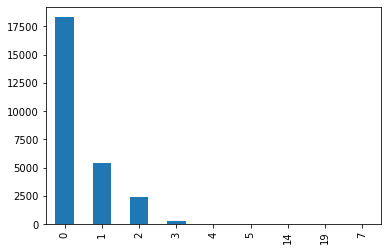

In [ ]:
# (1) child_num 
train['child_num'].value_counts(sort=False).plot.bar()

In [ ]:
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

In [ ]:
print(train[['income_total']].head())
print(train['income_total'].describe())
train['income_total'].value_counts().head(20)
train['income_total'].value_counts().tail(20)

   income_total
0      202500.0
1      247500.0
2      450000.0
3      202500.0
4      157500.0
count    2.645700e+04
mean     1.873065e+05
std      1.018784e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: income_total, dtype: float64


594000.0    1
124200.0    1
134995.5    1
38700.0     1
61875.0     1
204750.0    1
33750.0     1
39600.0     1
62100.0     1
175950.0    1
145350.0    1
249750.0    1
661500.0    1
97731.0     1
92250.0     1
57150.0     1
51750.0     1
87448.5     1
227250.0    1
191700.0    1
Name: income_total, dtype: int64

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


<AxesSubplot:ylabel='Frequency'>

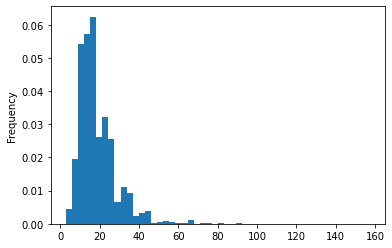

In [ ]:
#### (2) income
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000 
test['income_total'] = test['income_total']/10000
##############################################################3
print(train['income_total'].value_counts(bins=10,sort=False))
train['income_total'].plot(kind='hist',bins=50,density=True)

In [ ]:
count, bin_dividers =np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
#bin_dividers는 train기준!!
train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)


In [ ]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,1,1,0,0,소득0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,0,0,1,0,소득0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,0,0,1,0,소득0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,1,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,0,1,1,0,소득0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,소득0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
9996,36453,1,1,1,0,소득0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
9997,36454,0,0,1,0,소득1,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
9998,36455,0,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0


#### (3) Type

In [ ]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())


['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [ ]:
from sklearn import preprocessing

label_encoder=preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])
########################################################################
train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])
########################################################################
train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])
########################################################################
train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])
########################################################################
train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

#### 4. Minus continuous variable

In [ ]:
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움
    ##########################################################
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])